<a href="https://colab.research.google.com/github/Nega0619/AI/blob/main/GoogLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GoogLeNet을 Pytorch로 구현해 보았습니다.

pytorch 코드를 참고하였습니다.
https://github.com/pytorch/vision/blob/main/torchvision/models/googlenet.py

기타 참고 링크
https://deep-learning-study.tistory.com/523

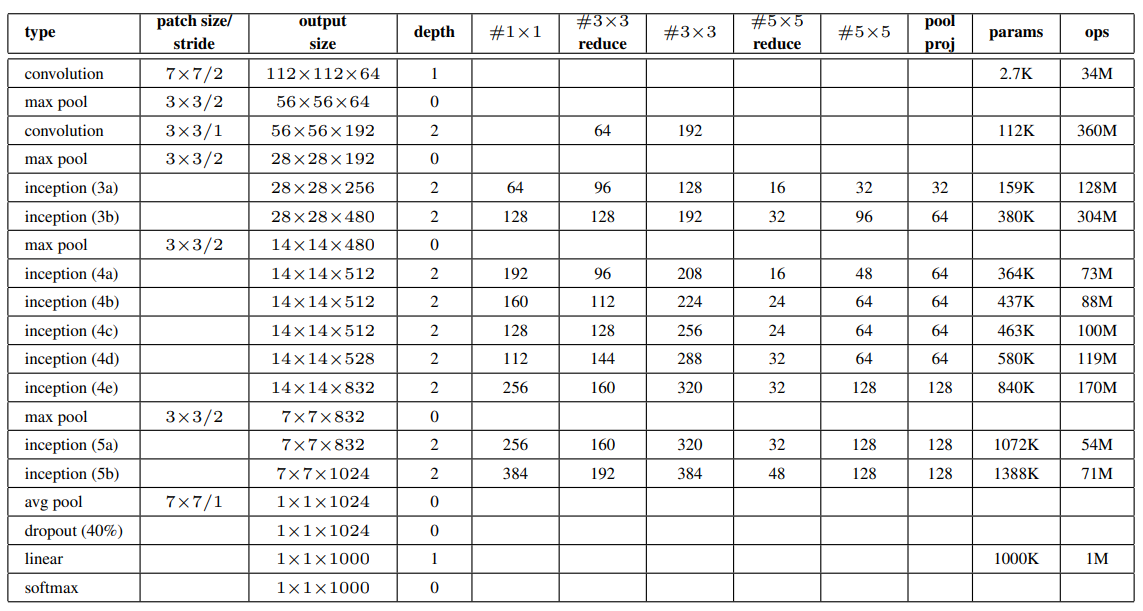

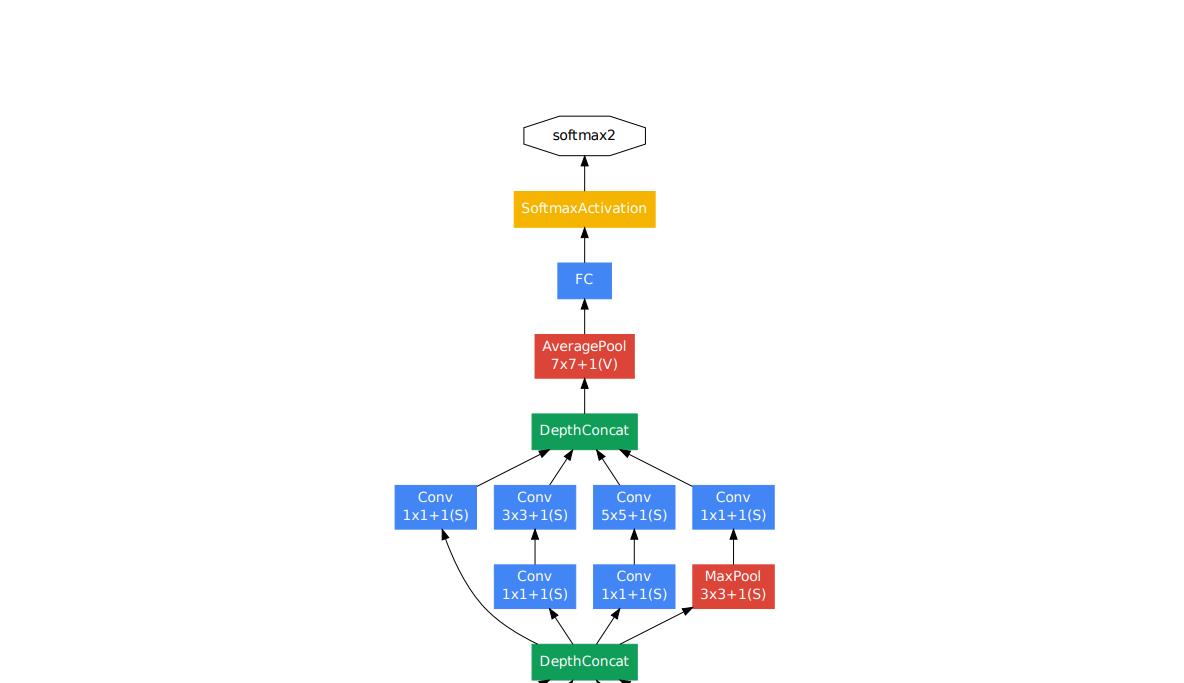

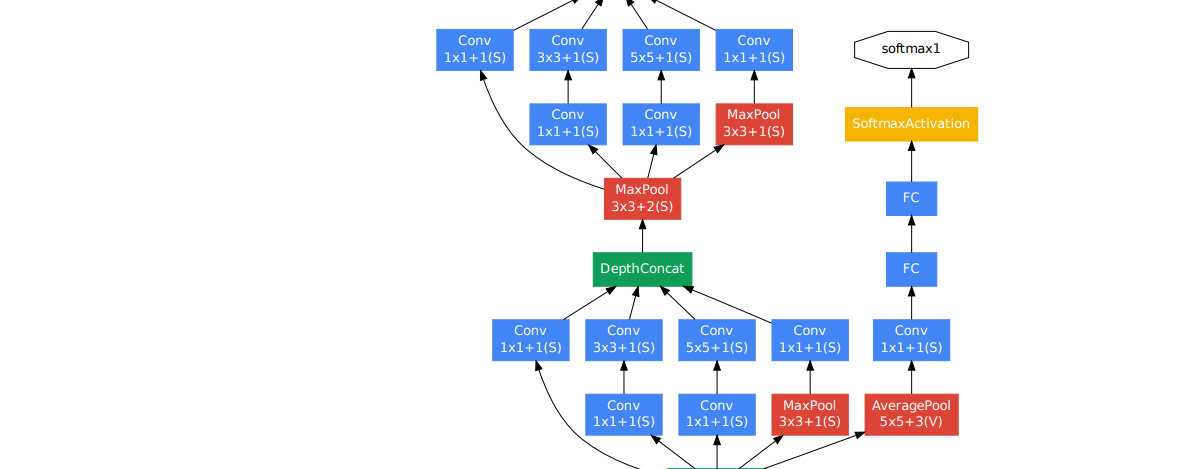

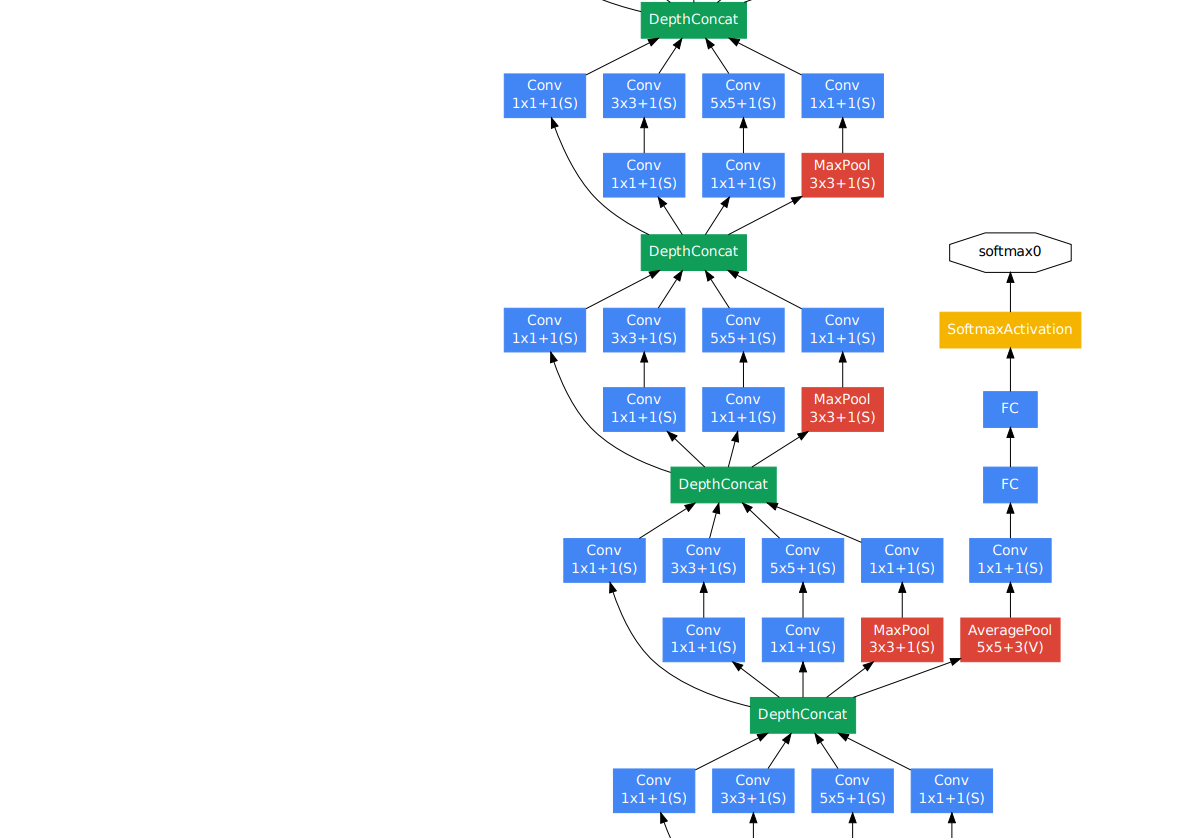

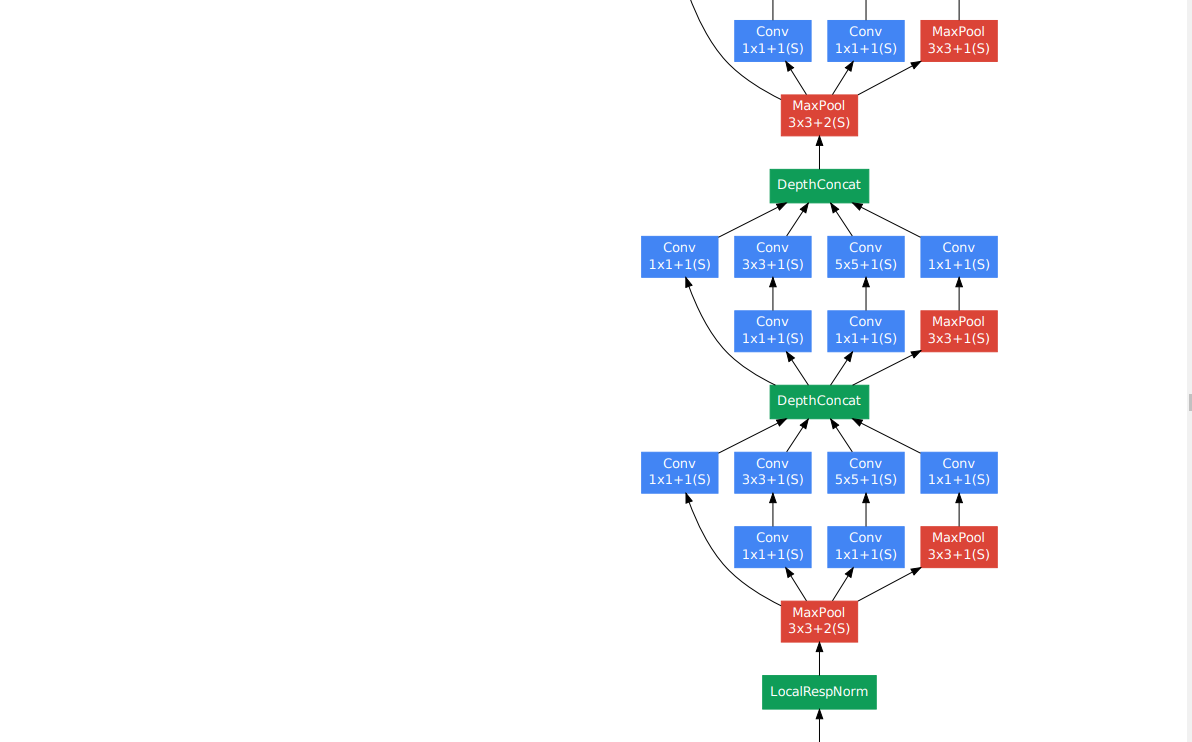

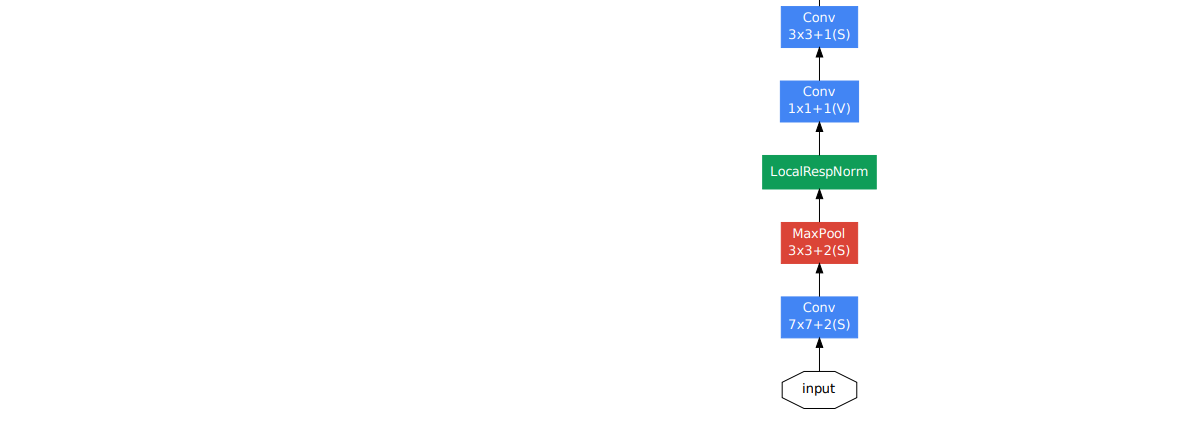

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torchsummary import summary

# 1. 제일 간단한 방법

Pytorch에 구현된 모델 불러오기 (이렇게 쉬울줄이야..)

In [13]:
from torchvision import models

google = models.GoogLeNet()
summary(google, (3, 224, 224))

/usr/local/lib/python3.7/dist-packages/torchvision/models/googlenet.py:51: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

# 2. 직접 구현하기

### basic conv

In [49]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels:int, out_channels:int, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x:Tensor) -> Tensor:
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x)            # inplace = True 옵션생략했음.

### inception_block

In [ ]:
class inception_block(nn.Module):
    def __init__(
        self,
        in_channels: int,
        ch1x1: int,
        ch3x3red: int,
        ch3x3: int,
        ch5x5red: int,
        ch5x5: int,
        pool_proj: int,
        ) -> None:
        super().__init__()


In [66]:
class my_GoogLeNet(nn.Module):
    def __init__(self, input_size=224):
        # super.__init__()
        super(my_GoogLeNet, self).__init__()

        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)       # padding = 3인데 일단 적용안하고 해봄 (안하면 output size가 맞지않음..)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)                                # ceil_mode=True 인데 뭔지몰라서안함.
        self.LocalRespNorm1 = nn.LocalResponseNorm(64)                          # pytorch 모델에는 없지만, 논문에는 있어서 넣어봄.
                                                                                # https://pytorch.org/docs/stable/generated/torch.nn.LocalResponseNorm.html
        self.conv2 = BasicConv2d(64, 64, kernel_size=1, stride = 1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, stride = 1, padding=1) # padding = 1안하면 output안맞음..
        self.LocalRespNorm2 = nn.LocalResponseNorm(192)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.LocalRespNorm1(x)

        x = self.conv2(x)
        x = self.conv3(x)
        x = self.LocalRespNorm2(x)
        x = self.maxpool2(x)


        return x


In [67]:
test = torch.randn(224,224, 3)
net = my_GoogLeNet()
summary(net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
 LocalResponseNorm-5           [-1, 64, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]           4,160
       BatchNorm2d-7           [-1, 64, 56, 56]             128
       BasicConv2d-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 192, 56, 56]         110,784
      BatchNorm2d-10          [-1, 192, 56, 56]             384
      BasicConv2d-11          [-1, 192, 56, 56]               0
LocalResponseNorm-12          [-1, 192, 56, 56]               0
        MaxPool2d-13          [-1, 192, 28, 28]               0
Total params: 125,056
Trainable params:

# 공부할 것

1. nn.MaxPool2d(3, stride=2, ceil_mode=True)

    원래는 MaxPool(3, 2)만 했는데 이 경우, output이  [-1, 64, 55, 55] 이다.
    `ceil_mode = True ` 혹은 `padding=1`을 주면  [-1, 64, 56, 56]이 맞춰지게 된다.(논문과 동일.)
    하지만 뭐가 다른지 모르므로 공부가 필요하다.

2. 대체 Pytorch에서 conv_block는 어디 선언되어있는가..

    아래 코드 블록 참고(pytorch model)
    ```
    class GoogLeNet(nn.Module):
    __constants__ = ["aux_logits", "transform_input"]

    def __init__(
            ....
    ) -> None:
        super().__init__()
        _log_api_usage_once(self)
        if blocks is None:
           ** blocks = [BasicConv2d, Inception, InceptionAux]**

           ....

        if len(blocks) != 3:
            raise ValueError(f"blocks length should be 3 instead of {len(blocks)}")
            ** conv_block = blocks[0] **
            ** inception_block = blocks[1] **
            ** inception_aux_block = blocks[2] **
    ```

        여기서 conv_block = block[0] = BasicConv2d(클래스)이다.
        클래스가 바로 생성되는 것.


3. 논문에서는 `LocalRespNorm`이 사용 되었는데, pytorch에서 구현된 것은 그냥 batch norm들이다. 

    3-1. LocalRespNorm 이 무엇인가

    3-2. LocalRespNorm이 의미하는 것이 batch normalization과 유사한가? 유사하다면, 이를 변경해도 되는 것인가? 이게 구현이 안된 이유는 무엇일까.



# 배운 코딩 꿀팁

1. **kwargs 를 인자로 받아서 그거 옵션 그대로 parameter로 넣어줄수있네
```
class BasicConv2d(nn.Module):
    def __init__(self, in_channels:int, out_channels:int, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
```

2. 파이썬에 데이터 타입 설정 안해도되는거 빡쳤었는데.. 이렇게하는거였넹 ㅎ parameter는 알았는데.. `->` 이거가 return값 설정이었구나.
```
    def forward(self, x:Tensor) -> Tensor:
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x)            # inplace = True 옵션생략했음.
```
